<a href="https://colab.research.google.com/github/xunxunshi/AirlineTweetsSemantics/blob/main/Final_Project_Airflight_Twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 

import pandas as pd  
import re
import regex as re
import wordcloud
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from collections import Counter
from numpy.random import default_rng
import spacy
from nltk.corpus import gutenberg
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix,classification_report
from scipy.sparse import csr_matrix
from sklearn.preprocessing import FunctionTransformer
from sklearn import metrics 
from sklearn.base import TransformerMixin,BaseEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
nltk.download('punkt')
import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
tweets=pd.read_csv(r'/content/Tweets.csv')

In [ ]:
tweets[['airline_sentiment','text','airline_sentiment_confidence']]

,airline_sentiment,text,airline_sentiment_confidence
0,neutral,@VirginAmerica What @dhepburn said.,1.0000
1,positive,@VirginAmerica plus you've added commercials t...,0.3486
2,neutral,@VirginAmerica I didn't today... Must mean I n...,0.6837
3,negative,@VirginAmerica it's really aggressive to blast...,1.0000
4,negative,@VirginAmerica and it's a really big bad thing...,1.0000
...,...,...,...
14635,positive,@AmericanAir thank you we got on a different f...,0.3487
14636,negative,@AmericanAir leaving over 20 minutes Late Flig...,1.0000
14637,neutral,@AmericanAir Please bring American Airlines to...,1.0000
14638,negative,"@AmericanAir you have my money, you change my ...",1.0000


# Preprocessing 

In [ ]:
 sentimentsConfidenceGreaterThanFifty=tweets[tweets['airline_sentiment_confidence']>0.5]

In [ ]:
sentimentsConfidenceGreaterThanFifty[['airline_sentiment','text','airline_sentiment_confidence']]

,airline_sentiment,text,airline_sentiment_confidence
0,neutral,@VirginAmerica What @dhepburn said.,1.0000
2,neutral,@VirginAmerica I didn't today... Must mean I n...,0.6837
3,negative,@VirginAmerica it's really aggressive to blast...,1.0000
4,negative,@VirginAmerica and it's a really big bad thing...,1.0000
5,negative,@VirginAmerica seriously would pay $30 a fligh...,1.0000
...,...,...,...
14634,negative,@AmericanAir right on cue with the delays👌,0.6684
14636,negative,@AmericanAir leaving over 20 minutes Late Flig...,1.0000
14637,neutral,@AmericanAir Please bring American Airlines to...,1.0000
14638,negative,"@AmericanAir you have my money, you change my ...",1.0000


In [ ]:
def return_split(passage):
  return (re.sub(r'[^\w\s]', '', str(passage).lower().strip()))

In [ ]:
def removeTweetAt(passage):
  return(re.sub(r'@(\w+)','',str(passage).lower().strip(), 1))


In [ ]:
nlp=spacy.load('en_core_web_sm')
def lemmatization(x):
  X_list=[]
  for token in nlp(x):
    lemma=token.lemma_
    X_list.append(lemma)
  return " ".join(X_list)

In [ ]:
sentimentsConfidenceGreaterThanFifty['text']=sentimentsConfidenceGreaterThanFifty['text'].apply(removeTweetAt)
sentimentsConfidenceGreaterThanFifty['text']=sentimentsConfidenceGreaterThanFifty['text'].apply(return_split)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
sentimentsConfidenceGreaterThanFifty.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,what dhepburn said,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,i didnt today must mean i need to take another...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,its really aggressive to blast obnoxious enter...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,and its a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,seriously would pay 30 a flight for seats that...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
sentimentsConfidenceGreaterThanFifty['airline_sentiment'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

## Feature Engineering 

In [ ]:
preprocess_tweet=sentimentsConfidenceGreaterThanFifty
x=preprocess_tweet['text']
y=preprocess_tweet['airline_sentiment']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,train_size=0.7,random_state=42)


### TF-IDF
As a first choice, we are using TF-IDF to transform our X (Passages) into vectors 
* TF-IDF is a vectorization algorithm which is used to represent textual data in numerical vectors . It gives weights to the words depending on their frequency. 
* Compared to bag of words, TF-IDF also calculates the inverse document frequency, which will factor in the frequency of the word to occur in all documents. This will take out very commonly used words. 
* The 'Fit' is used to identify the vocabulary and frequency whereas the 'Transform' is used for conversion to a vector.

In [ ]:
vec = TfidfVectorizer(binary=True, use_idf=True)
tfidf_train_data = vec.fit_transform(x_train) 
tfidf_test_data = vec.transform(x_test)

### Bag of words:
* Bag of words is a form of vectorization process for extracting features from the textual data. Like Tf-idf, this is another step of feature processing, but it does not take into account how often the words will appear across different documents. 
* The term 'bag' implies that the order of the words appearing in the document is ignored. The model is only concerned with whether the word is present in a document, not with the location of the word in the document.


In [ ]:
vec = CountVectorizer(binary=True)
Bow_train_data = vec.fit_transform(x_train) 
BOW_test_data = vec.transform(x_test) 

# Classification

## Visualization Functions

In [ ]:
def gridsearchResultstoDf(grid_search):
    results=pd.DataFrame(columns={'mean test score','mean train score','param', 'CV1 train loss','CV1 test loss', 'CV2 train loss','CV2 test loss', 'CV3 train loss','CV3 test loss',  'CV4 train loss','CV4 test loss', 'CV5 trainloss','CV5 test loss','CV6 train loss','CV6 test loss','CV7 train loss','CV7 test loss','CV8 train loss','CV8 test loss','CV9 train loss','CV9 test loss','CV10 train loss','CV10 test loss' })
    results=results[['mean test score','mean train score','param' , 'CV1 train loss','CV1 test loss', 'CV2 train loss','CV2 test loss', 'CV3 train loss','CV3 test loss',  'CV4 train loss','CV4 test loss', 'CV5 trainloss','CV5 test loss','CV6 train loss','CV6 test loss','CV7 train loss','CV7 test loss','CV8 train loss','CV8 test loss','CV9 train loss','CV9 test loss','CV10 train loss','CV10 test loss' ]]
    for mean_test_score,mean_train_score,params,testsplit0,testsplit1,testsplit2,testsplit3,testsplit4,testsplit5,testsplit6,testsplit7,testsplit8,testsplit9,trainsplit0,trainsplit1,trainsplit2,trainsplit3,trainsplit4,trainsplit5,trainsplit6,trainsplit7,trainsplit8,trainsplit9 in zip(grid_search.cv_results_["mean_test_score"],grid_search.cv_results_["mean_train_score"],grid_search.cv_results_["params"],grid_search.cv_results_["split0_test_score"],grid_search.cv_results_["split1_test_score"],grid_search.cv_results_["split2_test_score"],grid_search.cv_results_["split3_test_score"],grid_search.cv_results_["split4_test_score"],grid_search.cv_results_["split5_test_score"],grid_search.cv_results_["split6_test_score"],grid_search.cv_results_["split7_test_score"],grid_search.cv_results_["split8_test_score"],grid_search.cv_results_["split9_test_score"],grid_search.cv_results_["split0_train_score"],grid_search.cv_results_["split1_train_score"],grid_search.cv_results_["split2_train_score"],grid_search.cv_results_["split3_train_score"],grid_search.cv_results_["split4_train_score"],grid_search.cv_results_["split5_train_score"],grid_search.cv_results_["split6_train_score"],grid_search.cv_results_["split7_train_score"],grid_search.cv_results_["split8_train_score"],grid_search.cv_results_["split9_train_score"]):
        z=[mean_test_score,mean_train_score,params ,trainsplit0,testsplit0,trainsplit1,testsplit1,trainsplit2,testsplit2,trainsplit3,testsplit3,trainsplit4,testsplit4,trainsplit5,testsplit5,trainsplit6,testsplit6,trainsplit7,testsplit7,trainsplit8,testsplit8,trainsplit9,testsplit9]
        results.loc[len(results)]=z
    return results

In [ ]:
def plotLearningCurve(results,param,title):
  plt.figure(figsize=(10,6))
  plt.fill_between(results[param],results['mean test score']-results['test sdv'],results['mean test score']+results['test sdv'],alpha=0.1)
  plt.fill_between(results[param],results['mean train score']-results['train sdv'],results['mean train score']+results['train sdv'],alpha=0.1)
  plt.errorbar(results[param],results['mean test score'],results['test sdv'],label='Test Score (n=10)',fmt='-o')
  plt.errorbar(results[param],results['mean train score'],results['train sdv'],label='Train Score (n=10)',fmt='-o')
  plt.ylabel('Accuracy')
  plt.xlabel(param)
  plt.legend()
  plt.ylim(0,1)
  plt.title('Learning Curves from Cross validation of'+title)

In [ ]:
def plot_ROC(y_test,predictions,title):
  y_test_labelled = label_binarize(y_test, classes=['negative', 'neutral', 'positive' ])
  predictions_labelled = label_binarize(predictions, classes=['negative', 'neutral', 'positive' ])
  classes=['negative', 'neutral', 'positive' ]
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(3):
      fpr[i], tpr[i], _ = roc_curve(y_test_labelled[:, i], predictions_labelled[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_test_labelled.ravel(), predictions_labelled.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
  plt.figure(figsize=(10,6))
  for i in range(3):  
      plt.plot(fpr[i], tpr[i], label=str(classes[i])+': (area = %0.2f)' % roc_auc[i])
      plt.plot([0, 1], [0, 1], 'k--')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('ROC on Test Data'+str(title))
      plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left') 

In [ ]:
def plot_confusion_matrix(y_test,pred,title):
    mat = confusion_matrix(y_test,pred)
    plt.figure()
    axes = sns.heatmap(mat,square=True, annot=True,fmt='d',
                       cbar=True, cmap=plt.cm.BrBG)

    class_labels = ['negative', 'neutral', 'positive' ]

    axes.set_xlabel('Predicted Labels')
    axes.set_ylabel('Empirical Labels')

    tick_marks = np.arange(len(class_labels)) + 0.5

    axes.set_xticks(tick_marks)
    axes.set_xticklabels(class_labels,rotation=90)

    axes.set_yticks(tick_marks)
    axes.set_yticklabels(class_labels,rotation=0)

    axes.set_title('Confusion Matrix:'+title)

## SVC

### TFIDF 

In [ ]:
SVCparameters = {
  'C':[1,2,3,4,5,6,7,8,9,10],
  'loss': ['squared_hinge','hinge'], 
  }
clf=LinearSVC(random_state=101) 
grid_search=GridSearchCV(clf,SVCparameters,cv=10,return_train_score=True,scoring='accuracy')
grid_search.fit(tfidf_train_data,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv=10, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=101, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'loss': ['squared_hinge', 'hinge']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=0)

In [ ]:
results=gridsearchResultstoDf(grid_search)

In [ ]:
  results[results['mean test score']==results['mean test score'].max()].iloc[0]['param']

{'C': 1, 'loss': 'hinge'}

In [ ]:
temp_tree_cv_results=results
temp_tree_cv_results[['C','loss']]=temp_tree_cv_results['param'].apply(pd.Series)
temp_tree_cv_results['test sdv']=temp_tree_cv_results[['CV1 test loss','CV2 test loss','CV3 test loss','CV4 test loss','CV5 test loss','CV6 test loss','CV7 test loss','CV9 test loss','CV10 test loss']].std(axis=1)
temp_tree_cv_results['train sdv']=temp_tree_cv_results[['CV1 train loss','CV2 train loss','CV3 train loss','CV4 train loss','CV5 trainloss','CV6 train loss','CV7 train loss','CV9 train loss','CV10 train loss']].std(axis=1)

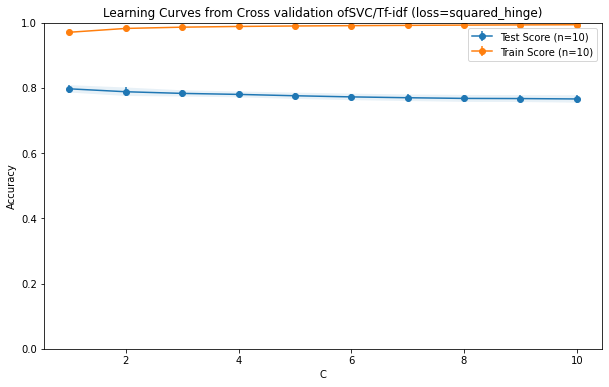

In [ ]:
resultsSVC=temp_tree_cv_results[temp_tree_cv_results['loss']=='squared_hinge']
plotLearningCurve(resultsSVC,'C','SVC/Tf-idf (loss=squared_hinge)')


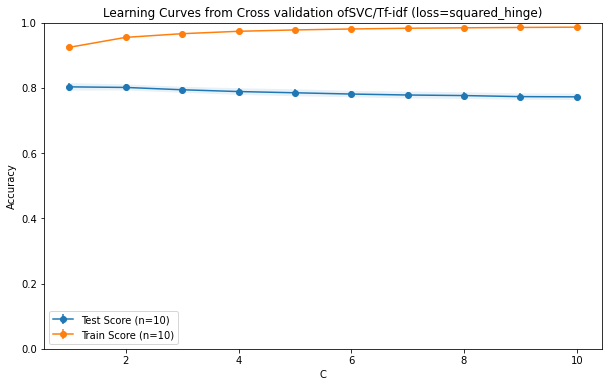

In [ ]:
resultsSVC=temp_tree_cv_results[temp_tree_cv_results['loss']=='hinge']
plotLearningCurve(resultsSVC,'C','SVC/Tf-idf (loss=squared_hinge)')


In [ ]:
clf=LinearSVC(C=1,loss='hinge')
clf.fit(tfidf_train_data,y_train)
predictions= clf.predict(tfidf_test_data)    

In [ ]:
 print(confusion_matrix(y_test,predictions)) 
    

[[2601  139   42]
 [ 346  465   55]
 [ 146   60  468]]


In [ ]:
cf_matrix=confusion_matrix(y_test,predictions) 

In [ ]:
 print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

    negative       0.84      0.93      0.89      2782
     neutral       0.70      0.54      0.61       866
    positive       0.83      0.69      0.76       674

    accuracy                           0.82      4322
   macro avg       0.79      0.72      0.75      4322
weighted avg       0.81      0.82      0.81      4322



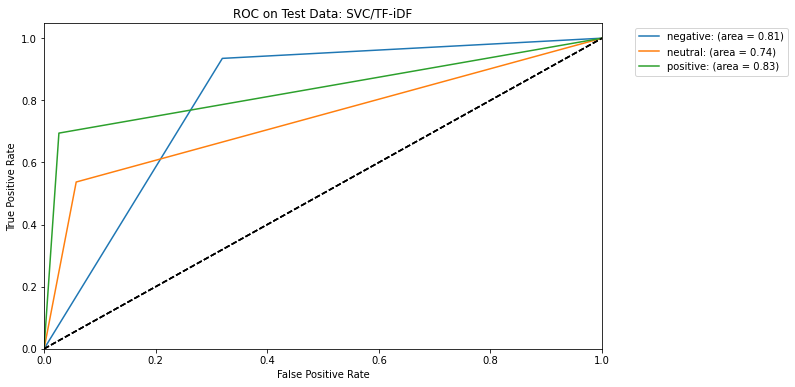

In [ ]:

plot_ROC(y_test,predictions,': SVC/TF-iDF')

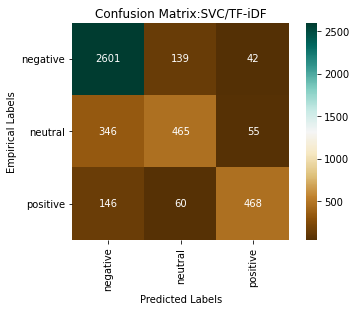

In [ ]:
plot_confusion_matrix(y_test,predictions,'SVC/TF-iDF')

### BOW 

In [ ]:
SVCparameters = {
  'C':[1,2,3,4,5,6,7,8,9,10],
  'loss': ['squared_hinge','hinge'], 
  }
clf=LinearSVC(random_state=101) 
grid_search=GridSearchCV(clf,SVCparameters,cv=10,return_train_score=True,scoring='accuracy')
grid_search.fit(Bow_train_data,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv=10, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=101, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'loss': ['squared_hinge', 'hinge']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=0)

In [ ]:
results=gridsearchResultstoDf(grid_search)
print(results[results['mean test score']==results['mean test score'].max()].iloc[0]['param'])
temp_tree_cv_results=results
temp_tree_cv_results[['C','loss']]=temp_tree_cv_results['param'].apply(pd.Series)
temp_tree_cv_results['test sdv']=temp_tree_cv_results[['CV1 test loss','CV2 test loss','CV3 test loss','CV4 test loss','CV5 test loss','CV6 test loss','CV7 test loss','CV9 test loss','CV10 test loss']].std(axis=1)
temp_tree_cv_results['train sdv']=temp_tree_cv_results[['CV1 train loss','CV2 train loss','CV3 train loss','CV4 train loss','CV5 trainloss','CV6 train loss','CV7 train loss','CV9 train loss','CV10 train loss']].std(axis=1)

{'C': 1, 'loss': 'hinge'}


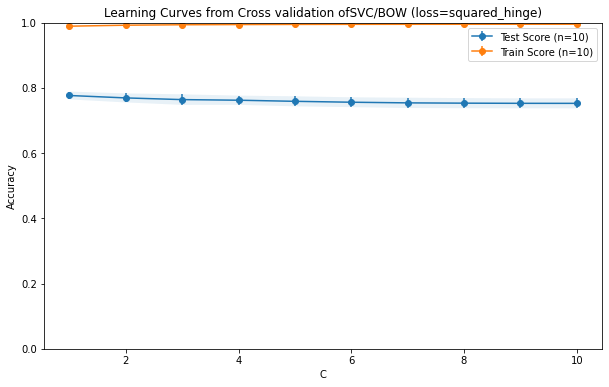

In [ ]:
resultsSVC=temp_tree_cv_results[temp_tree_cv_results['loss']=='squared_hinge']
plotLearningCurve(resultsSVC,'C','SVC/BOW (loss=squared_hinge)')


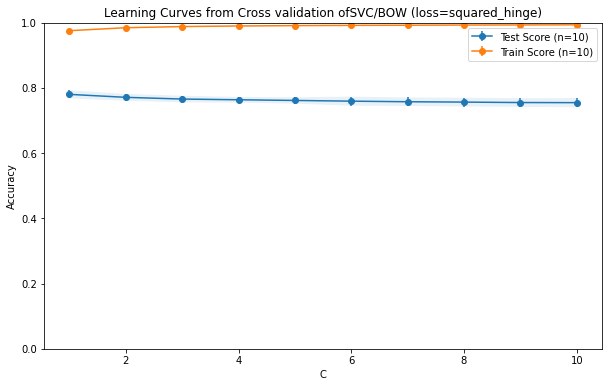

In [ ]:
resultsSVC=temp_tree_cv_results[temp_tree_cv_results['loss']=='hinge']
plotLearningCurve(resultsSVC,'C','SVC/BOW (loss=squared_hinge)')


In [ ]:
clf=LinearSVC(C=1,loss='hinge')
clf.fit(Bow_train_data,y_train)
predictions= clf.predict(BOW_test_data)    

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
cf_matrix=confusion_matrix(y_test,predictions)
 

In [ ]:
 print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

    negative       0.87      0.87      0.87      2782
     neutral       0.59      0.63      0.61       866
    positive       0.75      0.70      0.72       674

    accuracy                           0.79      4322
   macro avg       0.74      0.73      0.73      4322
weighted avg       0.79      0.79      0.79      4322



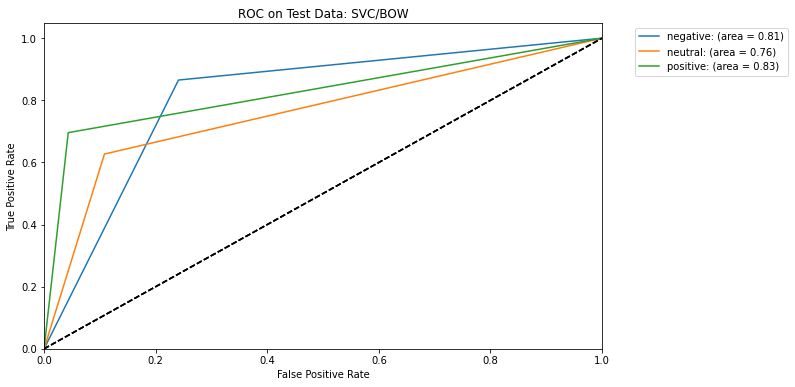

In [ ]:
plot_ROC(y_test,predictions,': SVC/BOW')

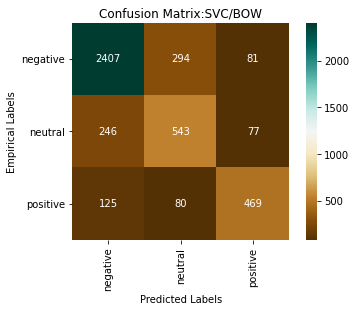

In [ ]:
plot_confusion_matrix(y_test,predictions,'SVC/BOW')

## Random Forest Algorithm
Random forest is a supervised learning algorithm which operates on a large number of decision trees grouped together. Each individual tree returns class predictions and the class with the most votes will be selected. Since the correlation between the models is low, this algorithm is prone to less errors.
### Hyper parameter tuning and cross validation with grid search: 
* We are performing the hyper parameter tuning on:
 * whether to use bootstrap
 * n_estimators (5-500)
* The number of trees is set using the n_estimators parameter which is by default set to 100. With increase in the number of trees the performance usually stabilizes.
* If bootstrap parameter is set to True then bootstrap samples are used. If false, training dataset is used to build the trees. 
* Note that we did not investigate other parameters such as tree depth or number of split. We used the default values of 100 and 2 for those. 
* Use a grid search to search for the best combination of these parameters 
* During this grid search we try each of the parameter combination on 10 cross validations 
* This cross validation is splitting the training data into 10 seperate parts, and holding one part out for testing each time 

In [ ]:
def GridSearchRF(x_train,y_train,FeatureEng):
  RFparameters = {
  'bootstrap':['True','False'],
  'n_estimators': [5,50,100,250],
  }
  clf=RandomForestClassifier(random_state=20) 
  grid_searchRF=GridSearchCV(clf,RFparameters,cv=10,return_train_score=True,scoring='accuracy')
  grid_searchRF.fit(x_train,y_train)
  results=gridsearchResultstoDf(grid_searchRF)
  results.sort_values(by='mean test score')
  results[results['mean test score']==results['mean test score'].max()].iloc[0]['param']
  # grid_searchRF.best_params_
  temp_tree_cv_results=results
  temp_tree_cv_results[['bootstrap','n_estimators']]=temp_tree_cv_results['param'].apply(pd.Series)
  temp_tree_cv_results['test sdv']=temp_tree_cv_results[['CV1 test loss','CV2 test loss','CV3 test loss','CV4 test loss','CV5 test loss','CV6 test loss','CV7 test loss','CV9 test loss','CV10 test loss']].std(axis=1)
  temp_tree_cv_results['train sdv']=temp_tree_cv_results[['CV1 train loss','CV2 train loss','CV3 train loss','CV4 train loss','CV5 trainloss','CV6 train loss','CV7 train loss','CV9 train loss','CV10 train loss']].std(axis=1)
  resultsSVC=temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='False']
  plotLearningCurve(resultsSVC,'n_estimators','Random Forest/'+FeatureEng +'(bootstrap=False)')
  resultsSVC=temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='False']
  plotLearningCurve(resultsSVC,'n_estimators','Random Forest/'+FeatureEng+'(bootstrap=True)')


In [ ]:
def evaluateResults_RF(x_train,y_train,x_test,y_test,FeatureEng,ifBootStrap,n_estimators): 

  clf=RandomForestClassifier (bootstrap=ifBootStrap, n_estimators= n_estimators)
  clf.fit(x_train,y_train)
  predictions= clf.predict(x_test)    
  cf_matrix=confusion_matrix(y_test,predictions)
  sns.heatmap(cf_matrix, annot=True)
  print(classification_report(y_test,predictions))
  plot_ROC(y_test,predictions,': Random Forest/'+FeatureEng)
  plot_confusion_matrix(y_test,predictions,' Random Forest/'+FeatureEng)

### TFIDF

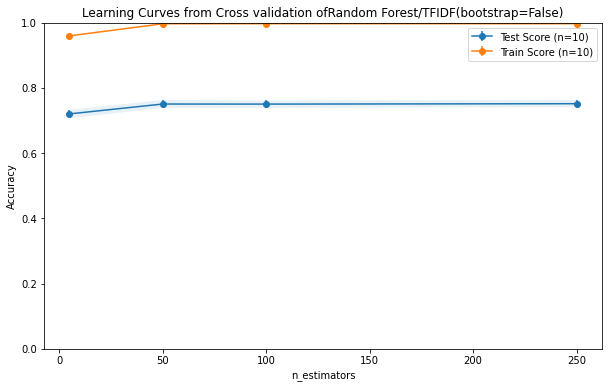

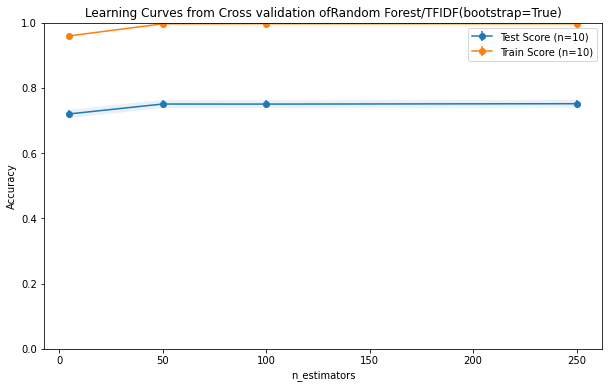

In [ ]:
GridSearchRF(tfidf_train_data,y_train,'TFIDF')

              precision    recall  f1-score   support

    negative       0.77      0.96      0.85      2782
     neutral       0.68      0.40      0.50       866
    positive       0.87      0.45      0.59       674

    accuracy                           0.77      4322
   macro avg       0.77      0.60      0.65      4322
weighted avg       0.77      0.77      0.74      4322



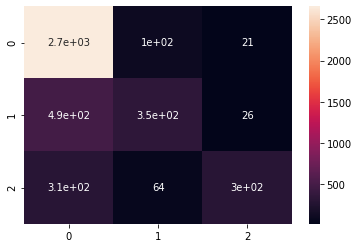

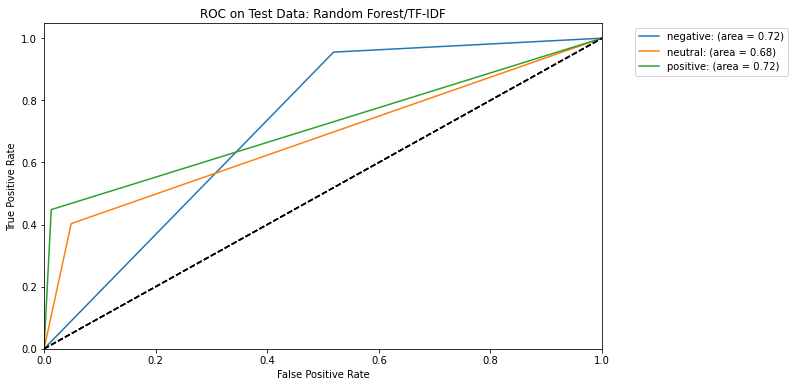

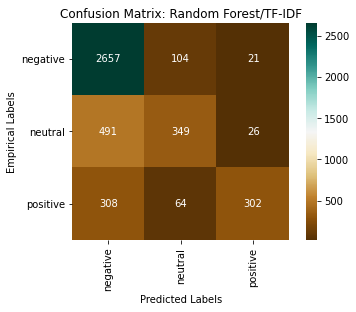

In [ ]:
evaluateResults_RF(tfidf_train_data,y_train,tfidf_test_data,y_test,'TF-IDF',True,50)

### BOW

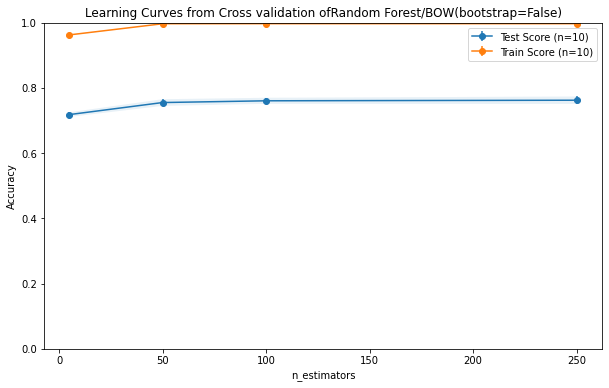

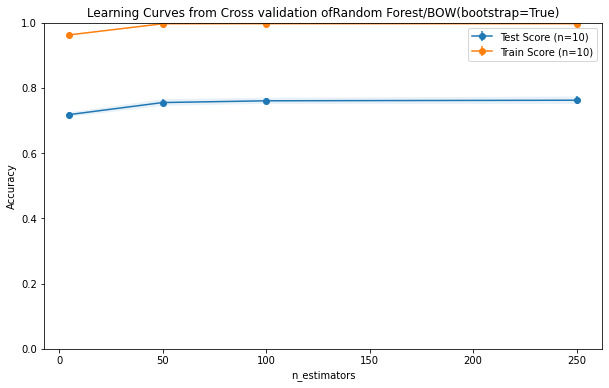

In [ ]:
GridSearchRF(Bow_train_data,y_train,'BOW')

              precision    recall  f1-score   support

    negative       0.79      0.96      0.86      2782
     neutral       0.69      0.42      0.52       866
    positive       0.83      0.51      0.63       674

    accuracy                           0.78      4322
   macro avg       0.77      0.63      0.67      4322
weighted avg       0.77      0.78      0.76      4322



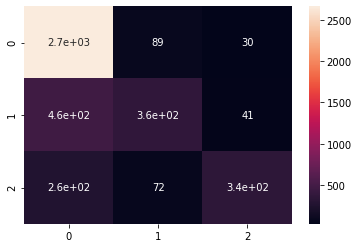

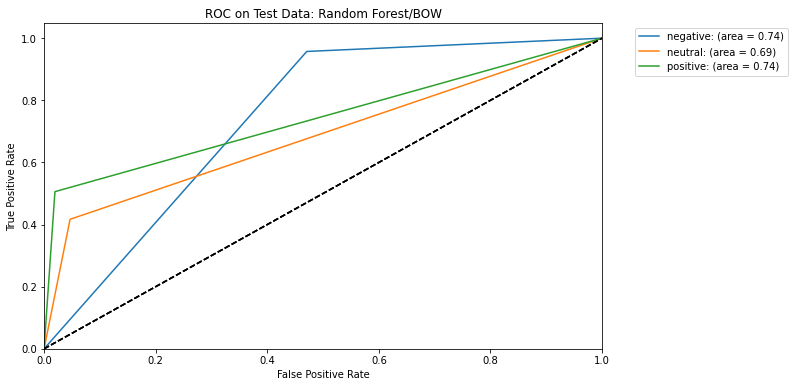

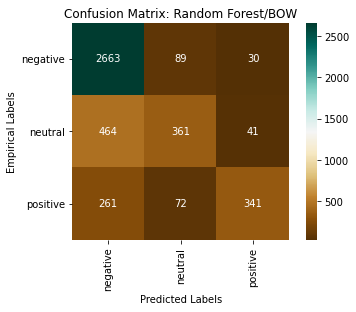

In [ ]:
evaluateResults_RF(Bow_train_data,y_train,BOW_test_data,y_test,'BOW',False,50)

In [ ]:
 GridSearchRF(x_train_w2v,y_train_w2v,'W2V')

In [ ]:
evaluateResults_RF(x_train_w2v,y_train_w2v,x_test_w2v,y_test_w2v,'W2V',ifBootStrap,n_estimators)

## Naive-Bayes Algorithm  
Naive Bayes Classifier uses probabilities to predict the outcome. The name basically implies that the outcome of one feature is independent of occurences of other features.
### Hyper parameter tuning and cross validation 
* we are performing hyper parameter tuning on:
 * var_smoothing 
* var_smoothing or laplace smoothing is used to solve the problem of occurence of zeroes that result from frequency based probabilities. The zeroes appear when a combination of feature and a class variable is not available.
* Use a grid search to identify the best combination of these parameters 
* During this grid search we try each of the parameter combination on 10 cross validations 
* This cross validation is splitting the training data into 10 seperate parts, and holding one part out for testing each time 

### TF-IDF 

In [ ]:
def GridSearchNV(x_train,y_train,FeatureEng):
 

  nb_classifier = GaussianNB()
  params_NB = {'var_smoothing': np.logspace(0,-9, num=10)}
    
  grid_searchNB=GridSearchCV(nb_classifier,params_NB,cv=10,return_train_score=True,scoring='accuracy')
  grid_searchNB.fit(x_train.todense(),y_train) 
  results=gridsearchResultstoDf(grid_searchNB)
  temp_nb_cv_results=results
  temp_nb_cv_results[['var_smoothing']]=results['param'].apply(pd.Series)
  temp_nb_cv_results['test sdv']=results[['CV1 test loss','CV2 test loss','CV3 test loss','CV4 test loss','CV5 test loss','CV6 test loss','CV7 test loss','CV9 test loss','CV10 test loss']].std(axis=1)
  temp_nb_cv_results['train sdv']=results[['CV1 train loss','CV2 train loss','CV3 train loss','CV4 train loss','CV5 trainloss','CV6 train loss','CV7 train loss','CV9 train loss','CV10 train loss']].std(axis=1)

  results.sort_values(by='var_smoothing',inplace=True)
  plotLearningCurve(results,'var_smoothing','NV/'+FeatureEng  ) 

In [ ]:
def evaluateResults_NV(x_train,y_train,x_test,y_test,FeatureEng,var_smoothing): 
  clf=GaussianNB (var_smoothing=var_smoothing )
  clf.fit(x_train.todense(),y_train)
  predictions= clf.predict(x_test.todense())    
  cf_matrix=confusion_matrix(y_test,predictions)
  sns.heatmap(cf_matrix, annot=True)
  print(classification_report(y_test,predictions))
  plot_ROC(y_test,predictions,': Naives Bayes/'+FeatureEng)
  plot_confusion_matrix(y_test,predictions,' Naives Bayes/'+FeatureEng)

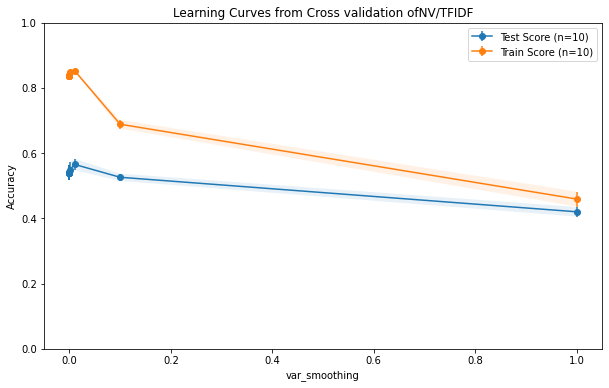

In [ ]:
GridSearchNV(tfidf_train_data,y_train,'TFIDF')

              precision    recall  f1-score   support

    negative       0.88      0.62      0.73      2782
     neutral       0.44      0.48      0.46       866
    positive       0.36      0.78      0.49       674

    accuracy                           0.61      4322
   macro avg       0.56      0.62      0.56      4322
weighted avg       0.71      0.61      0.64      4322



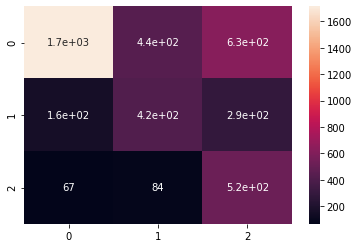

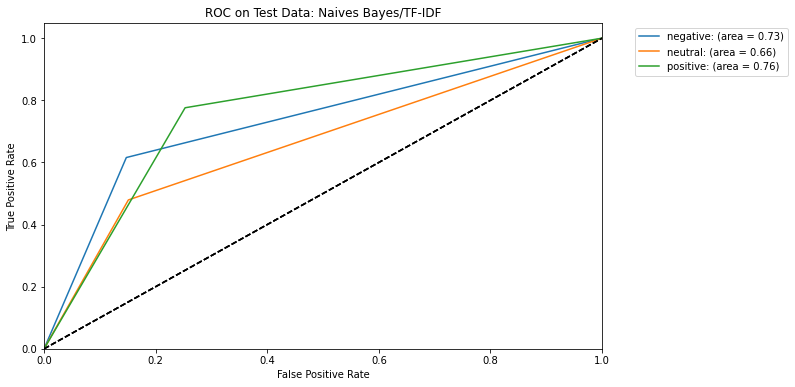

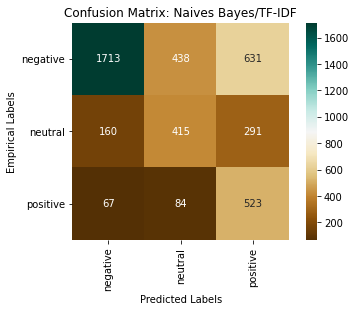

In [ ]:
evaluateResults_NV(tfidf_train_data,y_train,tfidf_test_data,y_test,'TF-IDF',0.01)

### BOW

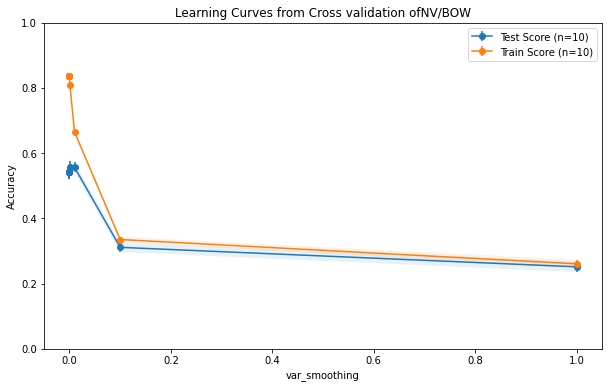

In [ ]:
GridSearchNV(Bow_train_data,y_train,'BOW')

              precision    recall  f1-score   support

    negative       0.95      0.50      0.66      2782
     neutral       0.44      0.45      0.45       866
    positive       0.32      0.94      0.47       674

    accuracy                           0.56      4322
   macro avg       0.57      0.63      0.53      4322
weighted avg       0.75      0.56      0.59      4322



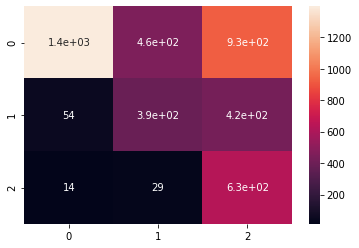

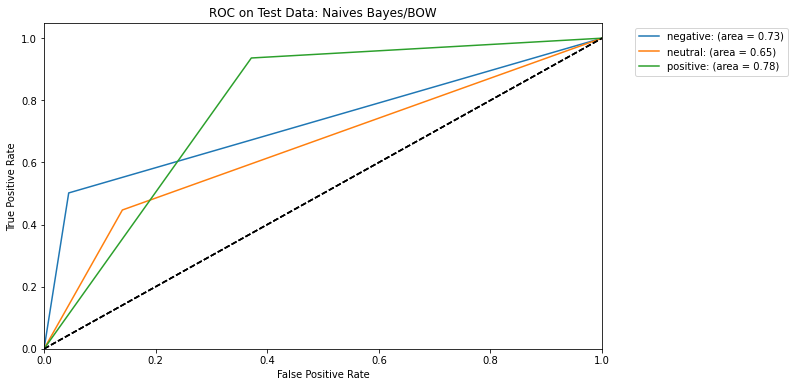

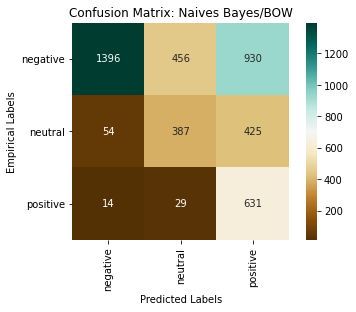

In [ ]:
evaluateResults_NV(Bow_train_data,y_train,BOW_test_data,y_test,'BOW',0.01)

## Ensemble Methods 

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
def evaluateResults_VotingClassifier(x_train,y_train,x_test,y_test,FeatureEng): 

  linearclf=LinearSVC(C=1,loss='hinge')
  RFclf=RandomForestClassifier (bootstrap=True, n_estimators= 50)
  NBclf=GaussianNB (var_smoothing=0.01 ) 

  voting_clf=VotingClassifier(estimators=[('linear', linearclf),  ('NV', NBclf), ('rf', RFclf)], voting='hard') 
  voting_clf.fit(x_train.todense(),y_train)
  predictions= voting_clf.predict(x_test.todense())    
  cf_matrix=confusion_matrix(y_test,predictions)
  sns.heatmap(cf_matrix, annot=True)
  print(classification_report(y_test,predictions))
  plot_ROC(y_test,predictions,': Ensemble Hard voting /'+FeatureEng)
  plot_confusion_matrix(y_test,predictions,' Ensemble Hard voting /'+FeatureEng)

              precision    recall  f1-score   support

    negative       0.82      0.95      0.88      2782
     neutral       0.74      0.48      0.58       866
    positive       0.84      0.67      0.75       674

    accuracy                           0.81      4322
   macro avg       0.80      0.70      0.74      4322
weighted avg       0.81      0.81      0.80      4322



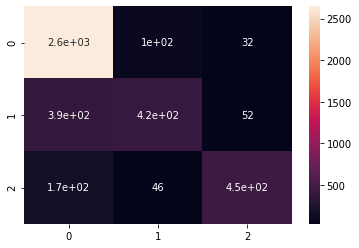

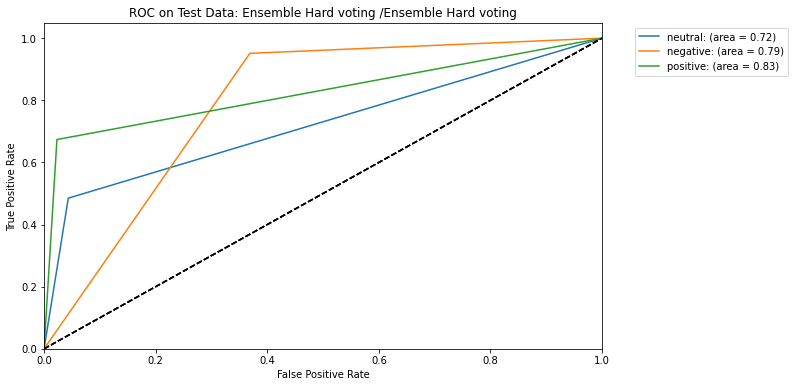

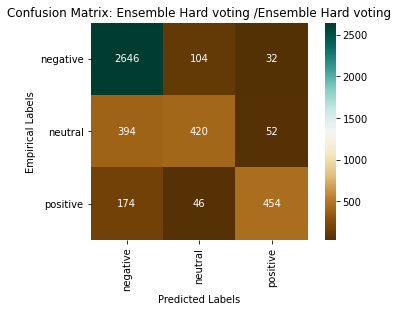

In [ ]:
 evaluateResults_VotingClassifier(tfidf_train_data,y_train,tfidf_test_data,y_test,'Ensemble Hard voting')

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

    negative       0.84      0.90      0.87      2782
     neutral       0.65      0.52      0.58       866
    positive       0.76      0.72      0.74       674

    accuracy                           0.80      4322
   macro avg       0.75      0.71      0.73      4322
weighted avg       0.79      0.80      0.79      4322



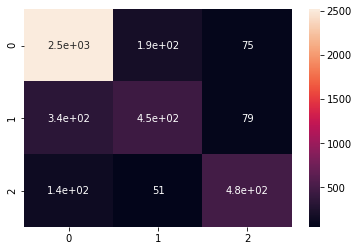

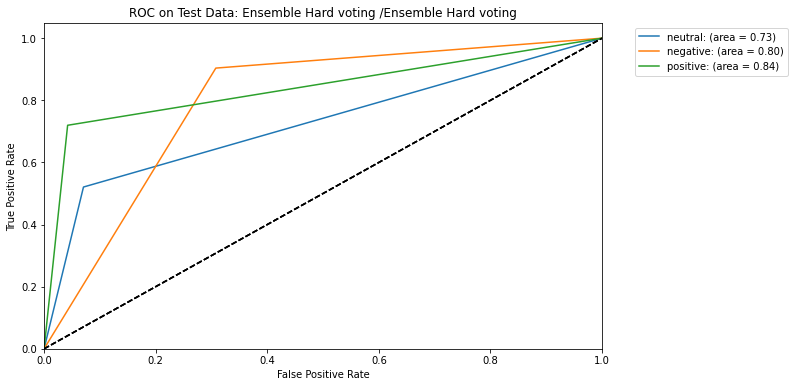

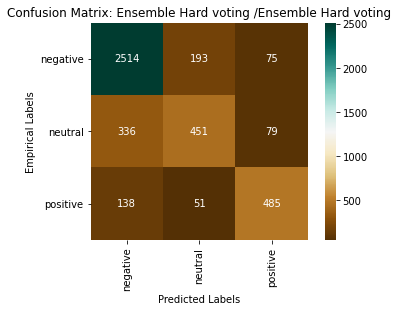

In [ ]:
 evaluateResults_VotingClassifier(Bow_train_data,y_train,BOW_test_data,y_test,'Ensemble Hard voting')

 ## Ensemble Methods with SMOTE (Imbalanced Dataset)

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 42)
X_res_Bow, y_res_bow = sm.fit_resample(Bow_train_data,y_train)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

    negative       0.87      0.88      0.87      2782
     neutral       0.62      0.59      0.61       866
    positive       0.72      0.73      0.72       674

    accuracy                           0.80      4322
   macro avg       0.74      0.73      0.73      4322
weighted avg       0.79      0.80      0.79      4322



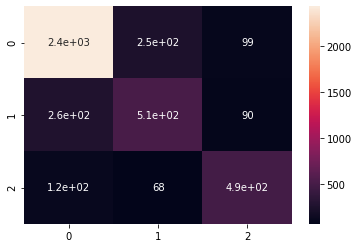

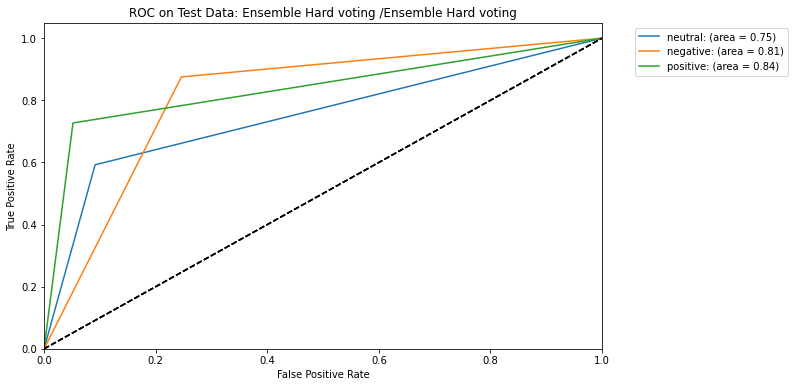

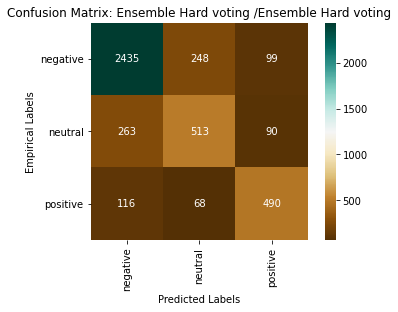

In [ ]:
X_res_TFIDF, y_res_TFIDF = sm.fit_resample(tfidf_train_data,y_train)
evaluateResults_VotingClassifier(X_res_TFIDF, y_res_TFIDF,tfidf_test_data,y_test,'Ensemble Hard voting')

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

    negative       0.87      0.85      0.86      2782
     neutral       0.60      0.62      0.61       866
    positive       0.71      0.73      0.72       674

    accuracy                           0.79      4322
   macro avg       0.73      0.73      0.73      4322
weighted avg       0.79      0.79      0.79      4322



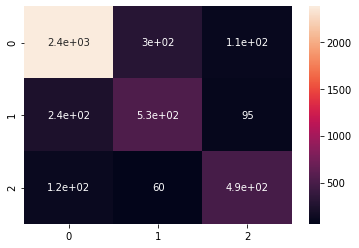

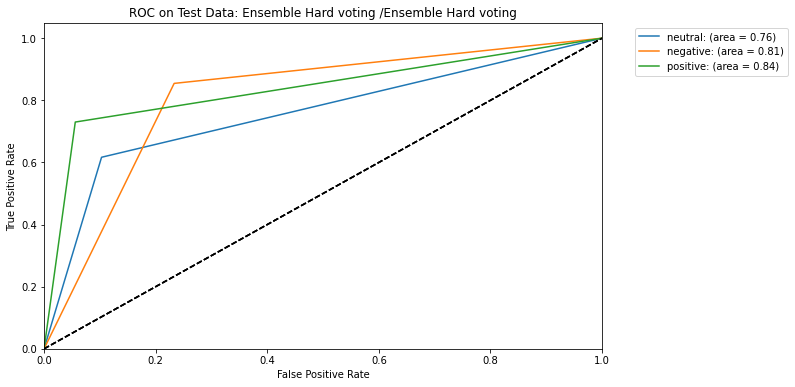

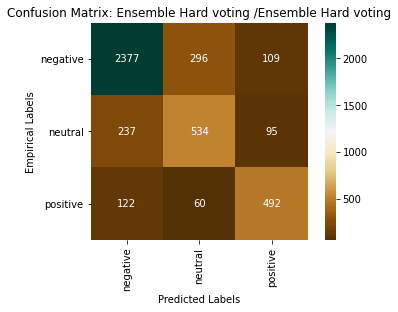

In [ ]:
 evaluateResults_VotingClassifier(X_res_Bow, y_res_bow ,BOW_test_data,y_test,'Ensemble Hard voting')

## Error Analysis of Classification 

In [ ]:
clf=LinearSVC(C=1,loss='hinge')
clf.fit(tfidf_train_data, y_train)
predictions= clf.predict(tfidf_test_data)    

In [ ]:
 totalListoferrors=pd.DataFrame(columns=['input','predictions','labels'])
for input, prediction, label in zip(x_test, predictions, y_test):
  if prediction != label:
    listOfErrors=[input,prediction,label]
    totalListoferrors.loc[len(totalListoferrors)]=listOfErrors
totalListoferrors.groupby(by=['predictions','labels']).count()

input
predictions labels         
negative    neutral     346
            positive    146
neutral     negative    139
            positive     60
positive    negative     42
            neutral      55

In [ ]:
 totalListoferrors[(totalListoferrors['predictions']=='negative')&(totalListoferrors['labels']=='neutral')]

,input,predictions,labels
0,how many 787s do you currently operate and wha...,negative,neutral
6,is there nothing that can be done online to he...,negative,neutral
7,barzegar charges tourists 700 euros a night f...,negative,neutral
8,may want to direct that to the people at furry...,negative,neutral
10,flight 280,negative,neutral
...,...,...,...
774,dont i always,negative,neutral
776,i need someone to help me out,negative,neutral
777,its time for our brandmance 2 go upwherewebelo...,negative,neutral
778,hey i missed my outbound flight can i still u...,negative,neutral


In [ ]:
 totalListoferrors[(totalListoferrors['predictions']=='negative')&(totalListoferrors['labels']=='neutral')].iloc[0]['input']

'how many 787s do you currently operate and what other aircraft do you operate'

In [ ]:
 totalListoferrors[(totalListoferrors['predictions']=='negative')&(totalListoferrors['labels']=='neutral')].iloc[1]['input']

'is there nothing that can be done online to help i bought these as a birthday present just trying to be able to afford a change'

In [ ]:
 totalListoferrors[(totalListoferrors['predictions']=='negative')&(totalListoferrors['labels']=='neutral')].iloc[2]['input']

'barzegar charges tourists 700 euros  a night for their stay in the tent village he runs httptcoigsvzvrbbn'

In [ ]:
 totalListoferrors[(totalListoferrors['predictions']=='negative')&(totalListoferrors['labels']=='neutral')].iloc[3]['input']

'may want to direct that to the people at furryfiesta tok'

In [ ]:
 totalListoferrors[(totalListoferrors['predictions']=='negative')&(totalListoferrors['labels']=='neutral')].iloc[5]['input']

'traveling with 3 young kids chose our original flights for a reason'

In [ ]:
for i in range(0,len( totalListoferrors[(totalListoferrors['predictions']=='negative')&(totalListoferrors['labels']=='neutral')])):
  print( totalListoferrors[(totalListoferrors['predictions']=='negative')&(totalListoferrors['labels']=='neutral')].iloc[i]['input'])

how many 787s do you currently operate and what other aircraft do you operate
is there nothing that can be done online to help i bought these as a birthday present just trying to be able to afford a change
barzegar charges tourists 700 euros  a night for their stay in the tent village he runs httptcoigsvzvrbbn
may want to direct that to the people at furryfiesta tok
flight 280
traveling with 3 young kids chose our original flights for a reason
just left laguardia nowsunshine in a little over 2 hours
does your home airport not count in the badge system my tb account says 2 flights but ive taken 3 this year
so i dont know confirmation number or the names of the flight attendants and supervisor
can i get assistance on flight 611 plane just landed from hpn and i have a connection to atl
which type plane is flt 1065 from bos to rsw
lister to my show my on monday 1230 130
will 2396 be cancelled flightled tonight
there is nothing on my usair cc at this point but the email stated i would be ch

In [ ]:
totalListoferrors[(totalListoferrors['predictions']=='negative')&(totalListoferrors['labels']=='neutral')]['input'].sum()

'how many 787s do you currently operate and what other aircraft do you operateis there nothing that can be done online to help i bought these as a birthday present just trying to be able to afford a changebarzegar charges tourists 700 euros  a night for their stay in the tent village he runs httptcoigsvzvrbbnmay want to direct that to the people at furryfiesta tokflight 280traveling with 3 young kids chose our original flights for a reasonjust left laguardia nowsunshine in a little over 2 hoursdoes your home airport not count in the badge system my tb account says 2 flights but ive taken 3 this yearso i dont know confirmation number or the names of the flight attendants and supervisorcan i get assistance on flight 611 plane just landed from hpn and i have a connection to atlwhich type plane is flt 1065 from bos to rswlister to my show my on monday 1230 130will 2396 be cancelled flightled tonightthere is nothing on my usair cc at this point but the email stated i would be charged  thank

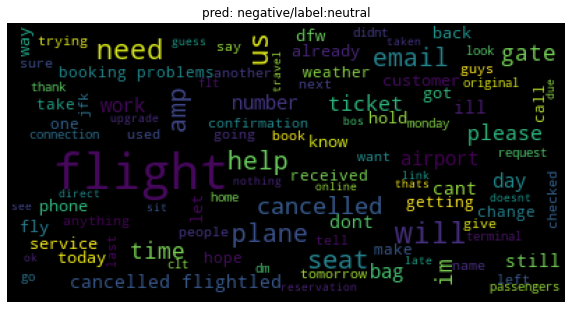

In [ ]:
wordc = wordcloud.WordCloud(background_color='black', max_words=100, 
                         max_font_size=35)
wc = wordc.generate(str( totalListoferrors[(totalListoferrors['predictions']=='negative')&(totalListoferrors['labels']=='neutral')]['input'].sum()))
fig = plt.figure(num=1,figsize=(10,6))
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.title('pred: negative/label:neutral'	)
plt.show()
